In [1]:
import bbknn
import numpy as np
import pandas as pd
import matplotlib.pyplot as pl
from matplotlib import rcParams
import scanpy as sc
import os
sc.settings.verbosity = 3  # verbosity: errors (0), warnings (1), info (2), hints (3)
sc.logging.print_versions()

scanpy==1.4.1 anndata==0.6.19 numpy==1.14.3 scipy==1.1.0 pandas==0.24.2 scikit-learn==0.20.0 statsmodels==0.8.0 python-igraph==0.7.1 louvain==0.6.1 


In [ ]:
dirname = os.getcwd()
print(dirname)
save_dir = dirname
data_dir = '../Data/dataset6'

In [ ]:
# Create folder to save the results 
def save_images(basename):
    if not os.path.exists('./visualization'): os.makedirs('./visualization')
    
    outname = './visualization/' + basename + '.png'
    pl.savefig(outname, dpi=150)
    pl.close()
    
    
# Function to plot TSNE
def plotTSNE(adata, color_group, n_pcs=20, perplexity=90, save_filename='tsne', use_repx = False):
    #adata.var_names_make_unique()
    if use_repx:
        sc.tl.tsne(adata, random_state=0, n_pcs=n_pcs, perplexity=perplexity, use_rep='X')
    else:    
        sc.tl.tsne(adata, random_state=0, n_pcs=n_pcs, perplexity=perplexity)
    sc.pl.tsne(adata, color = color_group, show=False, wspace=.3)
    save_images(save_filename)     
    
def plotUMAP(adata, color_group, save_filename, use_repx = False):
    
#     if use_repx:
#         sc.pp.neighbors(adata, use_rep='X')
#     else:    
#         sc.pp.neighbors(adata,n_neighbors=10, n_pcs=20)
        
    sc.tl.umap(adata)
    sc.pl.umap(adata, color = color_group, show=False)
    save_images(save_filename) 

In [4]:
# read data from read count text table, data from R: genes x cells
adata1 = pd.read_csv(os.path.join(data_dir,'b1_exprs.txt'),sep='\t',header=0, index_col=0)
adata2 = pd.read_csv(os.path.join(data_dir,'b2_exprs.txt'),sep='\t',header=0, index_col=0)
adata3 = pd.read_csv(os.path.join(data_dir,'b3_exprs.txt'),sep='\t',header=0, index_col=0)
adata = pd.concat([adata1, adata2, adata3], axis=1)
adata = sc.AnnData(np.transpose(adata))
print(adata)
print(adata.obs_names[1:3])
print(adata.var_names[1:3])

AnnData object with n_obs × n_vars = 9531 × 32738 
Index(['293t_AAACATACAGACTC', '293t_AAACATTGACCAAC'], dtype='object')
Index(['FAM138A', 'OR4F5'], dtype='object')


In [5]:
sample_adata1 = pd.read_csv(os.path.join(data_dir,'b1_celltype.txt'),header=0, index_col=0, sep='\t')
sample_adata1['batch'] = 'batch1'
sample_adata2 = pd.read_csv(os.path.join(data_dir,'b2_celltype.txt'),header=0, index_col=0, sep='\t')
sample_adata2['batch'] = 'batch2'
sample_adata3 = pd.read_csv(os.path.join(data_dir,'b3_celltype.txt'),header=0, index_col=0, sep='\t')
sample_adata3['batch'] = 'batch3'
sample_adata = pd.concat([sample_adata1, sample_adata2, sample_adata3], axis=0)
print(sample_adata.values.shape)
print(sample_adata.keys())

(9531, 2)
Index(['CellType', 'batch'], dtype='object')


In [8]:
adata.obs['cell_type'] = sample_adata.loc[adata.obs_names,['CellType']]
adata.obs['batch'] = sample_adata.loc[adata.obs_names,['batch']]
# Save output into h5ad, easy to access 
# adata.write_h5ad(os.path.join(data_dir,'dataset6.h5ad'))
adata1 = adata

... storing 'cell_type' as categorical
... storing 'batch' as categorical


AnnData object with n_obs × n_vars = 9531 × 32738 
    obs: 'cell_type', 'batch'

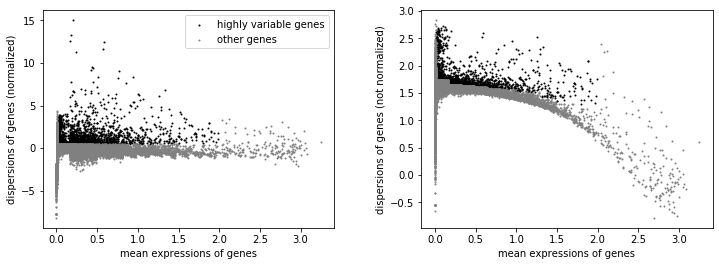

[2221, 33694]


In [11]:
sc.pp.normalize_per_cell(adata1, counts_per_cell_after=1e4)
filter_result = sc.pp.filter_genes_dispersion(adata1.X, min_mean=0.0125, max_mean=2, min_disp=0.5)
sc.pl.filter_genes_dispersion(filter_result)
print([sum([i[0] for i in filter_result]),len(filter_result)])

In [12]:
adata1 = adata1[:, filter_result.gene_subset]
print(adata1)

View of AnnData object with n_obs × n_vars = 15476 × 2221 
    obs: 'cell_type', 'batch', 'n_counts'


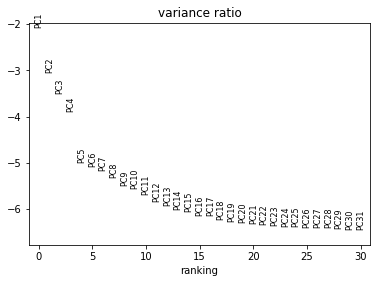

In [13]:
sc.pp.log1p(adata1)
#sc.pp.scale(adata1, max_value=10)
sc.tl.pca(adata1, svd_solver='arpack')
adata1.obsm['X_pca'] *= -1  # multiply by -1 to match Seurat
sc.pl.pca_variance_ratio(adata1, log=True)

In [ ]:
num_pcs = 20
sc.pp.neighbors(adata1,n_pcs=num_pcs, n_neighbors=20)
sc.tl.umap(adata1)
color_group = ['cell_type','batch']
sc.pl.umap(adata1, color=color_group,save='raw.png')

computing neighbors
    using 'X_pca' with n_pcs = 20


computing batch balanced neighbors
    finished (0:09:10.38) --> added to `.uns['neighbors']`
    'distances', weighted adjacency matrix
    'connectivities', weighted adjacency matrix
Took 0:09:12.856544
computing UMAP
    finished (0:00:14.51) --> added
    'X_umap', UMAP coordinates (adata.obsm)
saving figure to file ./figures/umapbbknn_trim.png


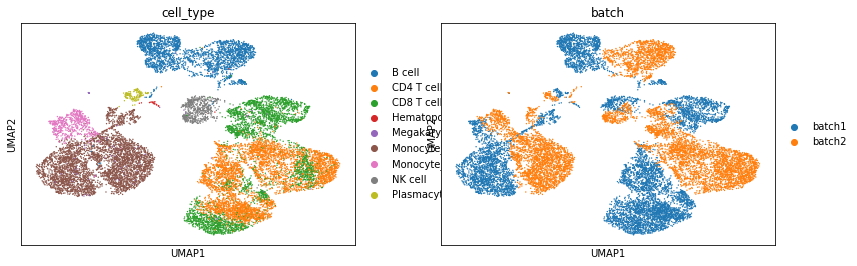

In [14]:
# BBKNN 
# BBKNN also offers a trim parameter, which filters each cell's connections 
# to a user-specified number of highest connectivities. 
# This can help increase cell type separation at a potential slight cost to batch mixing
adata_bbknn_trim = bbknn.bbknn(adata1,copy=True,neighbors_within_batch=5,trim=50,n_pcs=num_pcs,batch_key='batch') #approx=False,
sc.tl.umap(adata_bbknn_trim)
color_group = ['cell_type','batch']
sc.pl.umap(adata_bbknn_trim, color=color_group,save='bbknn_trim.png')
adata_bbknn_trim.write_h5ad(os.path.join(save_dir,'bbknn_trim.h5ad'))

In [31]:
sc.tl.pca(adata_bbknn_trim, svd_solver='arpack',n_comps=20)
print(adata_bbknn_trim)
adata_bbknn_trim.obsm['X_pca'] *= -1  # multiply by -1 to match Seurat

AnnData object with n_obs × n_vars = 14767 × 15558 
    obs: 'cell_type', 'batch', 'louvain'
    uns: 'pca', 'neighbors', 'louvain', 'cell_type_colors', 'batch_colors'
    obsm: 'X_pca', 'X_umap'
    varm: 'PCs'


In [19]:
color_group = ['cell_type','batch']
# Visualization UMAP
plotUMAP(adata_bbknn_trim, color_group, 'bbknn_umap')#

computing UMAP
    finished (0:00:14.76) --> added
    'X_umap', UMAP coordinates (adata.obsm)
computing tSNE
    using 'X_pca' with n_pcs = 10
    using sklearn.manifold.TSNE with a fix by D. DeTomaso
    finished (0:02:18.83) --> added
    'X_tsne', tSNE coordinates (adata.obsm)


In [20]:
# Visualization
import pandas as pd
print(adata_bbknn_trim)
colnu = []
for i in range(adata_bbknn_trim.obsm['X_umap'].shape[1]):
    colnu.append("UMAP"+str(i+1))
df = pd.DataFrame(adata_bbknn_trim.obsm['X_umap'], columns=colnu, index=adata_bbknn_trim.obs_names)
df['batch'] = pd.Series(adata_bbknn_trim.obs['batch'], index=adata_bbknn_trim.obs_names)
df['celltype'] = pd.Series(adata_bbknn_trim.obs['cell_type'], index=adata_bbknn_trim.obs_names)
df.to_csv(save_dir + '/visualization/bbknn_umap.csv')

AnnData object with n_obs × n_vars = 15476 × 33694 
    obs: 'cell_type', 'batch'
    uns: 'neighbors', 'cell_type_colors', 'batch_colors'
    obsm: 'X_pca', 'X_umap', 'X_tsne'
